## TrOCR

This notebook uses TrOCR to extract the digits and operators from the images provided. 
TrOCR is composed of 4 different versions:
- Stage1 - which is the model trained on a large volume of synthetic data;
- Handwritten - fine-tuned on the IAM dataset;
- Printed - which is fine-tuned on the SROIE dataset (digitalized receipts)
- Scene - for scene text recognition, identifying and localizing text within images of videos

Each of them have three version, with large version being the best performing but also the most computationaly expensive, and the smallest being faster but less accurate., except for Scene which only has small and base.


**Note**: This model is fine-tuned on the Mathwriting dataset on this [notebook](./trocr_fine_tune_mathwriting.ipynb)

In [96]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import cv2

import re

import matplotlib.pyplot as plt

from difflib import SequenceMatcher

import time


Similar to the other solutions used during this project, this notebook follows the same workflow:
![image info](../data/workflow.png)

- Image Loading
- Image Preprocessing - different solutions required different preprocessing techniques.
- Text Extraction - here, saving raw (before any processing) and after transformations to deal with spaces and different symbols for multiplication.
- Contour Detection - to detect where the characters are located in the provided image
- Evaluate Expression - which outputs the result of the expression in the image

In [97]:
start_time = time.time()

# loading the pre-trained TrOCR model and processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-stage1")

end_time = time.time()
loading_time = end_time - start_time  # Calculate the loading time

# to understand how long this takes to load
print(f"Model and processor loading time: {loading_time:.2f} seconds")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and processor loading time: 13.86 seconds


Here, we use the large version of Stage1's model. The large versions are more computationally expensive, but also their accuracy is also higher. 
The time necessary to load the processor and model is measured using the module **time**. After multiple runs, it was observed that it takes between 12 to 15 seconds to load.

In [98]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

# extracting the text from image
def predict_text_from_image(image):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # saving the raw extracted text before processing to confirm what the model predicted
    raw_extracted_text = generated_text  
    processed_text = generated_text.replace(" ", "").replace("x", "*").replace("X", "*")
    
    return raw_extracted_text, processed_text


In [99]:
def draw_bounding_boxes(image_path, predicted_text):
    image_cv = cv2.imread(image_path)
    if image_cv is None:
        raise ValueError(f"Image not found at path: {image_path}")
    image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    
    # converts the image to grayscale and threshold it for contour detection
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # this detects the contours which correspond to potential characters
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # sorts contours left-to-right based on x coordinate
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    # drawing the bounding boxes around each contour
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # filtering out small noise contours
        if w * h > 20:  
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 1)
    
    # displaying the image with bounding boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"TrOCR Result with Bounding Boxes\nExtracted Text: {predicted_text}")
    plt.show()

With the text extracted, it is now possible to calculate the result of the expression found in the image.

Here we replace the different characters used in handwriting for multiplication ("x" and "X") as well as removing blank spaces and the "=" sign contain in some of the images.

The following set of regular expressions ensures that the expression follows the proper format when it comes to multiplication, for cases of implied multiplications.

re.match() is used to ensure that the equation only contains valid characters (digits, +, -, *, /, (, ), and .).

In [100]:
def evaluate_equation(equation):
    equation = equation.replace("x", "*").replace("X", "*")
    equation = equation.replace(" ", "").replace("=", "")

    equation = re.sub(r"(\d)(\()", r"\1*(", equation)  # digit followed by "("
    equation = re.sub(r"(\))(\d)", r")*\2", equation)  # ")" followed by digit
    equation = re.sub(r"(\))(\()", r")*(", equation)   # ")" followed by "("

    if not re.match(r"^[\d\.\+\-\*/\(\)]+$", equation):
        return "Invalid Equation"
    
    try:
        result = eval(equation, {"__builtins__": None}, {})
        return result
    except (SyntaxError, ZeroDivisionError, NameError, TypeError) as e:
        return f"Error evaluating equation: {e}"

To check how the extraction went when compared to the ground truth, this function was provided.
We use the SequenceMatcher class difflib module, which measures the similarity between the two strings.

- CER, Character Error Rate, measure the number of wrongly predicted characters.
- The accuracy is defined as the ratio of matching characters to the total number of characters in the ground truth, represented in percentage.


In [101]:
def calculate_accuracy(raw_predicted_text, ground_truth_text):

    if not raw_predicted_text or not ground_truth_text:
        return 0.0  # returns 0% accuracy if there's nothing to compare

    ground_truth_text_cleaned = ground_truth_text.replace(" ", "")
    
    matcher = SequenceMatcher(None, raw_predicted_text, ground_truth_text_cleaned)
    match_ratio = matcher.ratio()  # returns the ratio of matching characters
    accuracy_percentage = match_ratio * 100
    
    return accuracy_percentage

In [102]:
def main(image_path, ground_truth):
    image = load_image(image_path)
    
    raw_predicted_text, predicted_text = predict_text_from_image(image)
    print("Raw Extracted Text:", raw_predicted_text)  # before any transformation
    print("Processed Extracted Text:", predicted_text)   # after regular expressions to deal with specific cases
    
    result = evaluate_equation(predicted_text)
    print("Calculated Result:", result)

    accuracy = calculate_accuracy(predicted_text, ground_truth)
    print(f"Accuracy: {accuracy:.2f}%")
    
    draw_bounding_boxes(image_path, predicted_text)

Raw Extracted Text: 26 2 + 513
Processed Extracted Text: 262+513
Calculated Result: 775
Accuracy: 100.00%


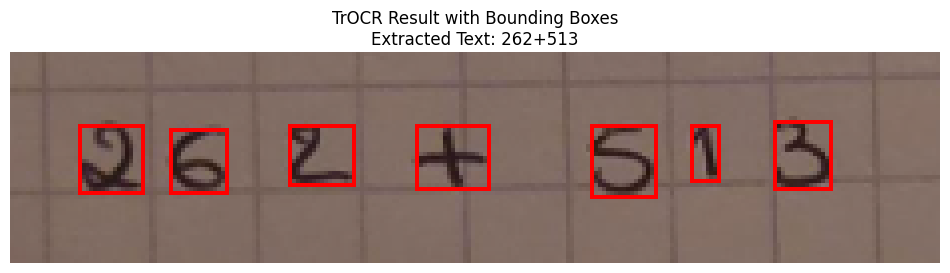

In [103]:
image_path = "../data/img_six.png"
ground_truth = "262+513"
main(image_path, ground_truth)



The bounding box is correctly drawn around all characters in the image and TrOCR is able to correctly predict the digits and operators, despite the background.
It detected a space, which by looking at the image, there's an uneven amount of space between the characters, so the space is a  correct assumption. 
Spaces and specific cases are dealt with with regular expressions.
evaluate_equation() correctly calculated the result. This is a very simple operation, but it'll also be tested on more complex operations involving parenthesis.

Raw Extracted Text: 45 + 19
Processed Extracted Text: 45+19
Calculated Result: 64
Accuracy: 100.00%


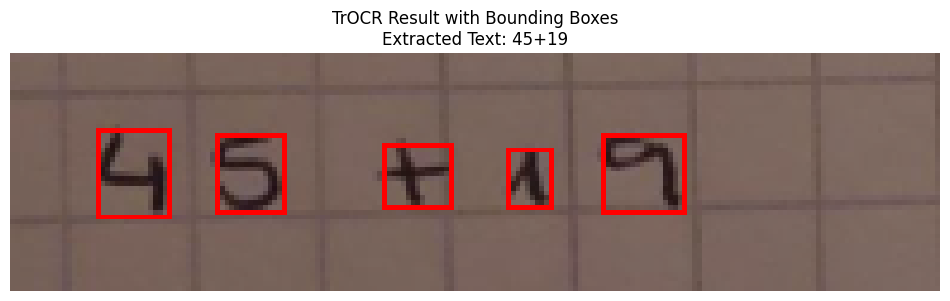

In [104]:
image_path = "../data/img_seven.png"
ground_truth = "45+19"
main(image_path, ground_truth)

Raw Extracted Text: 96 x 37
Processed Extracted Text: 96*37
Calculated Result: 3552
Accuracy: 80.00%


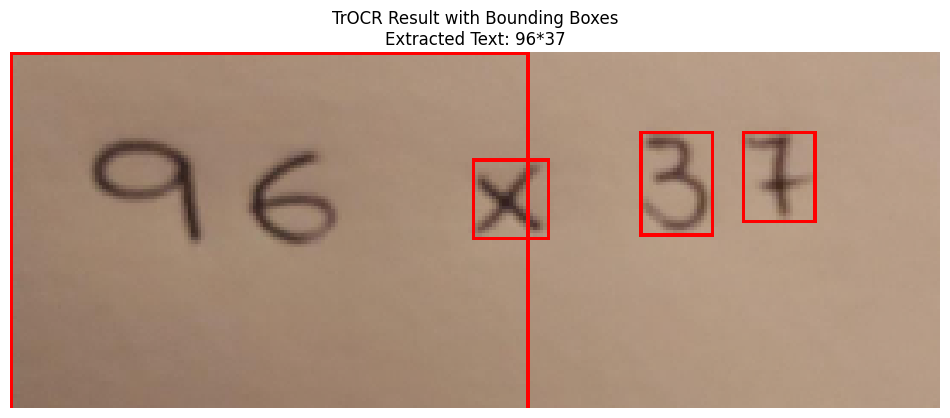

In [105]:
image_path = "../data/img_thirteen.png"
ground_truth = "96x37"
main(image_path, ground_truth)

Here, it can be observed the 

Raw Extracted Text: 45 * 12
Processed Extracted Text: 45*12
Calculated Result: 540
Accuracy: 100.00%


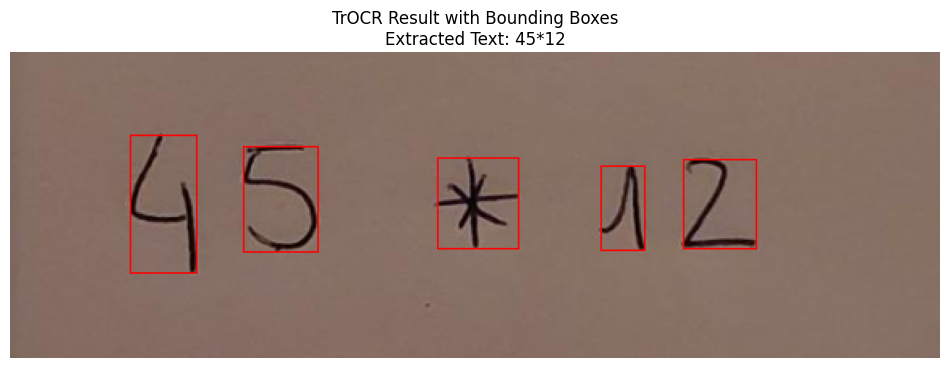

In [106]:
image_path = "../data/img_seventeen.png"
ground_truth = "45*12"
main(image_path, ground_truth)

Raw Extracted Text: 45 x 12
Processed Extracted Text: 45*12
Calculated Result: 540
Accuracy: 80.00%


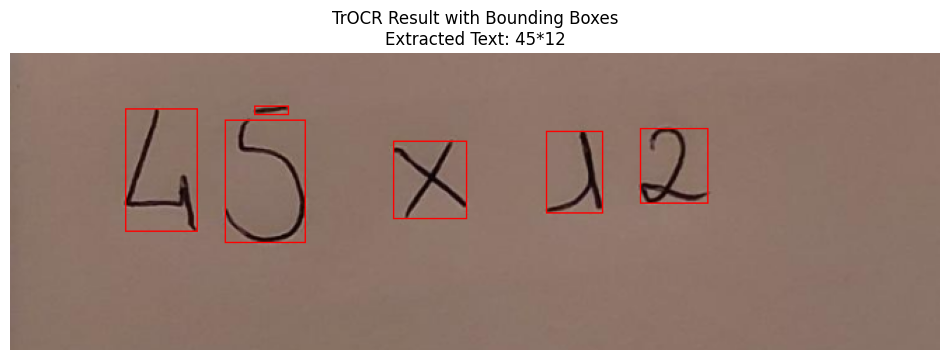

In [107]:
image_path = "../data/img_sixteen.png"
ground_truth = "45x12"
main(image_path, ground_truth)

Raw Extracted Text: 476 x 92
Processed Extracted Text: 476*92
Calculated Result: 43792
Accuracy: 83.33%


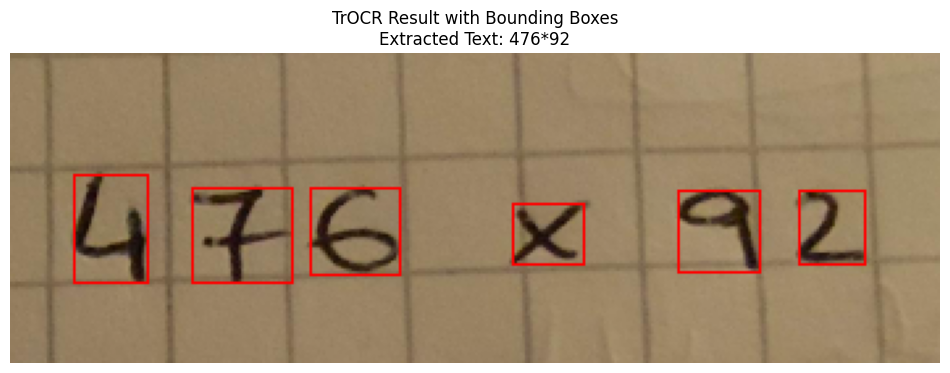

In [108]:
image_path = "../data/img_ten.png"
ground_truth = "476x92"
main(image_path, ground_truth)

Raw Extracted Text: 9 + 4 =
Processed Extracted Text: 9+4=
Calculated Result: 13
Accuracy: 100.00%


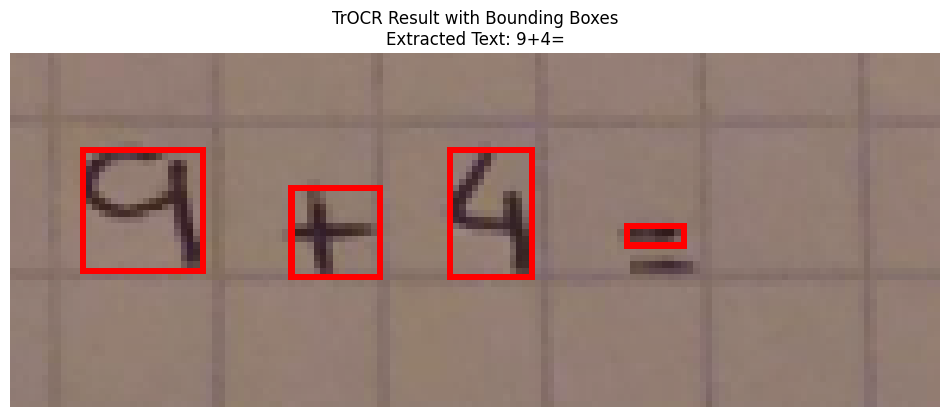

In [109]:
image_path = "../data/img_four.png"
ground_truth = "9+4="
main(image_path, ground_truth)

Raw Extracted Text: 3 ( 7 + 4 ) + ( 6 / 3 )
Processed Extracted Text: 3(7+4)+(6/3)
Calculated Result: 35.0
Accuracy: 100.00%


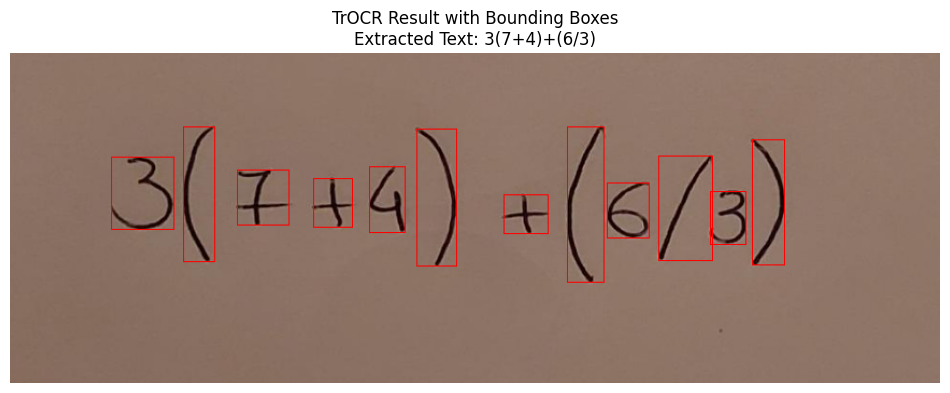

In [110]:
image_path = "../data/img_twenty.png"
ground_truth = "3(7+4)+(6/3)"
main(image_path, ground_truth)

We can observe that it recognized correctly the parenthesis and dealt with the operations in the image.